# Web attack detection using CNN-BiLSTM neural net and CICIDS2017 dataset

Training data: https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip

Training dataset is the balanced dataset based on CICIDS2017: https://paperswithcode.com/dataset/cicids2017
    
Sources:
- https://paperswithcode.com/paper/efficient-deep-cnn-bilstm-model-for-network
- Sinha, Jay & Manollas, M.. (2020). Efficient Deep CNN-BiLSTM Model for Network Intrusion Detection. 223-231. 10.1145/3430199.3430224.
- https://github.com/razor08/Efficient-CNN-BiLSTM-for-Network-IDS/blob/master/NSL_KDD_Final.ipynb
    

## Data preprocessing

In [1]:
import sys
import time
import pandas as pd
import numpy as np

import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import zscore
import matplotlib.pyplot as plt

Print modules' versions for reproducibility. This notebook was tested with:
- Python 3.6.9 and Tensorflow 1.14;
- Python 3.9.7 and Tensorflow 2.6.0;
- Python 3.10.2 and Tensorflow 2.8.0.

In [2]:
print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
print(sys.version)

2.6.0
1.4.1
1.21.5
1.0.2
3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


Download the dataset from Github to Google Colab and unzip it.

In [ ]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

### Preparing data for training

Load our dataset and separate it into feature vectors and labels.

In [4]:
data = pd.read_csv('web_attacks_balanced.csv', delimiter=',')

y = data['Label']
X = data.drop('Label', axis=1)

We use a function below for feature scaling which is needed for the correct functioning of selected deep learning algorithms (CNN and BiLSTM). In our case, the min-max normalization is used: all selected features are transformed into the range [0,1].

In [5]:
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy()
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

We normalize all features in the training set with the aforementioned function and print out the resulting training set.

In [6]:
combined_data_X = normalize(X,X.columns)
combined_data_X

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.676326,0.298636,0.605014,0.306733,0.000809,1.000000,0.754167,1.708356e-06,0.000053,0.000071,...,0.000054,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.662316,0.298636,0.413236,0.306733,0.000809,1.000000,0.754167,1.750023e-06,0.000053,0.000071,...,0.000054,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.663618,0.298636,0.428449,0.306733,0.000809,1.000000,0.754167,1.991026e-04,0.000053,0.000071,...,0.000054,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.773883,0.299593,0.038148,0.306733,0.000809,1.000000,0.754167,1.716689e-06,0.000053,0.000071,...,0.000054,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.389462,0.297440,0.559343,0.306733,0.000809,1.000000,0.754167,1.300017e-06,0.000053,0.000071,...,0.000054,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0.338897,0.415410,0.006760,0.306158,0.547819,0.352941,0.550000,4.750062e-07,0.000000,0.000036,...,0.000000,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7263,0.332276,0.113664,0.006760,0.306158,0.815914,0.352941,0.550000,5.000065e-07,0.000000,0.000036,...,0.000000,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7264,0.113860,0.236420,0.006760,0.306158,0.895222,0.352941,0.550000,7.083426e-07,0.000000,0.000036,...,0.000000,0.727273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7265,0.331731,0.107203,0.006760,0.306158,0.550260,0.352941,0.550000,7.250095e-07,0.000000,0.000036,...,0.000000,0.454545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check the absence of missing values in feature vectors and labels.

In [7]:
combined_data_X.isnull().values.any()

False

In [8]:
y_train = pd.DataFrame(y)
y_train.isnull().values.any()

False

As we can see, labels are categorical. We would need to transform them into the numeric form before the neural network training.

In [9]:
y_train

,Label
0,BENIGN
1,BENIGN
2,BENIGN
3,BENIGN
4,BENIGN
...,...
7262,BENIGN
7263,BENIGN
7264,BENIGN
7265,BENIGN


## The neural network preparation

Define and compile the neural network.
<p> We use a sequential model with CNN and BiLSTM layers, and batch normalization is applied before BiLSTM layers. A dropout layer is put before the final layer to prevent overfitting.
<p> Categorical crossentropy is chosen as a loss function because of the multiclass classification. To get the classification result, the softmax activation function is applied to the output of the last, fully connected layer. 

In [19]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=122, padding="same",activation="relu",input_shape=(83, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape = (128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 83, 64)            7872      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 64)            256       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               66048     
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 1)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 1)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 25, 1)            

## The neural network training

We use Stratified K-Folds cross-validation to conduct our experiment.

In [21]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
# The results of each fold
oos_pred = []

The training step is designed for the use with different versions of Tensorlow, if necessary. It is also possible to choose whether the training should be performed by CPU or GPU.

In [23]:
#Tensorflow 1.14

# This option may be used to speed up the CPU computation is some cases
#import os
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

# Configure session parameters for the optimal parallelization and choose the computational device (CPU, GPU or both)
#config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=48, inter_op_parallelism_threads=48, allow_soft_placement=True, device_count = {'CPU': 24})
#with tf.compat.v1.Session(config=config) as sess:

# Tensorflow 2.X, the computation is performed on CPU

with tf.device('/CPU:0'):

# Tensorflow 2.X, the computation is performed on GPU

#with tf.device('/GPU:0'):
    # Set a timer for the learning time evaluation
    start_time = time.time()

    # Stratified K-Folds cross-validation
    for train_index, test_index in kfold.split(combined_data_X,y_train):
        # Get the test data and the validation data for a current fold
        train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
        train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]

        print("train index:",train_index)
        print("test index:",test_index)

        x_train_array = train_X[combined_data_X.columns].values
        x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
        
        # One-Hot encoding for the training labels
        dummies = pd.get_dummies(train_y)
        outcomes = dummies.columns
        y_train_1 = dummies.values

        x_test_array = test_X[combined_data_X.columns].values
        x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))

        # One-Hot encoding for the validation labels
        dummies_test = pd.get_dummies(test_y)
        outcomes_test = dummies_test.columns
        y_test_2 = dummies_test.values

        # Fit the neural net model
        model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=10)

        # Apply the neural net model to the validation data and get the accuracy of this prediction
        pred = model.predict(x_test_2)
        pred = np.argmax(pred,axis=1)
        y_eval = np.argmax(y_test_2,axis=1)
        score = metrics.accuracy_score(y_eval, pred)
        oos_pred.append(score)
        print("Validation score: {}".format(score))

    # Get the learning time
    print('Total operation time: ', time.time() - start_time, 'seconds')

train index: [   5    6    7 ... 7262 7264 7265]
test index: [   0    1    2 ... 7258 7263 7266]
Epoch 1/10
114/114 [==============================] - 35s 311ms/step - loss: 0.0573 - accuracy: 0.9838 - val_loss: 3.6829 - val_accuracy: 0.0897
Epoch 2/10
114/114 [==============================] - 31s 271ms/step - loss: 0.0387 - accuracy: 0.9904 - val_loss: 2.1201 - val_accuracy: 0.3641
Epoch 3/10
114/114 [==============================] - 30s 259ms/step - loss: 0.0533 - accuracy: 0.9879 - val_loss: 0.8228 - val_accuracy: 0.6398
Epoch 4/10
114/114 [==============================] - 29s 259ms/step - loss: 0.0509 - accuracy: 0.9857 - val_loss: 0.0667 - val_accuracy: 0.9829
Epoch 5/10
114/114 [==============================] - 32s 279ms/step - loss: 0.0370 - accuracy: 0.9898 - val_loss: 0.0582 - val_accuracy: 0.9849
Epoch 6/10
114/114 [==============================] - 29s 257ms/step - loss: 0.0287 - accuracy: 0.9920 - val_loss: 0.0413 - val_accuracy: 0.9882
Epoch 7/10
114/114 [=============

## Results analysis and visualization

In [24]:
oos_pred

[0.992294991744634, 0.9986237269474264]

In [25]:
test_y.value_counts()

Label                     
BENIGN                        2543
Web Attack � Brute Force       754
Web Attack � XSS               326
Web Attack � Sql Injection      10
dtype: int64

In [26]:
from sklearn.metrics import confusion_matrix
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0,1,2,3])
confussion_matrix

array([[2543,    0,    0,    0],
       [   0,  752,    0,    2],
       [   0,    0,   10,    0],
       [   0,    0,    3,  323]], dtype=int64)

In [27]:
dummies

,Label_BENIGN,Label_Web Attack � Brute Force,Label_Web Attack � Sql Injection,Label_Web Attack � XSS
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
7256,1,0,0,0
7257,1,0,0,0
7258,1,0,0,0
7263,1,0,0,0


In [28]:
dummies_test.columns

Index(['Label_BENIGN', 'Label_Web Attack � Brute Force',
       'Label_Web Attack � Sql Injection', 'Label_Web Attack � XSS'],
      dtype='object')

In [30]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

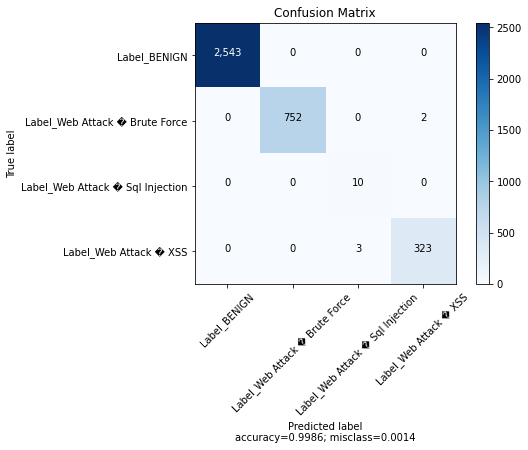

In [31]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ['Label_BENIGN', 'Label_Web Attack � Brute Force',
                                      'Label_Web Attack � Sql Injection', 'Label_Web Attack � XSS'],
                      title        = "Confusion Matrix")

C:\Users\Дом\AppData\Local\Temp\ipykernel_8980\162010504.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


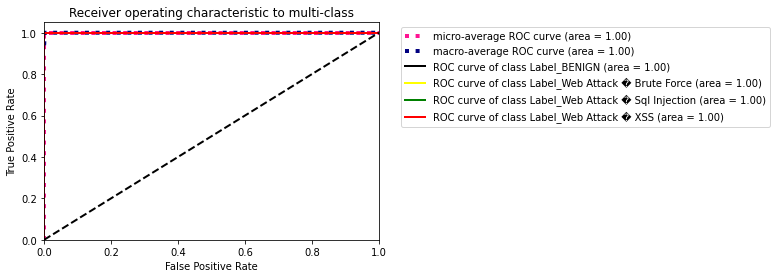

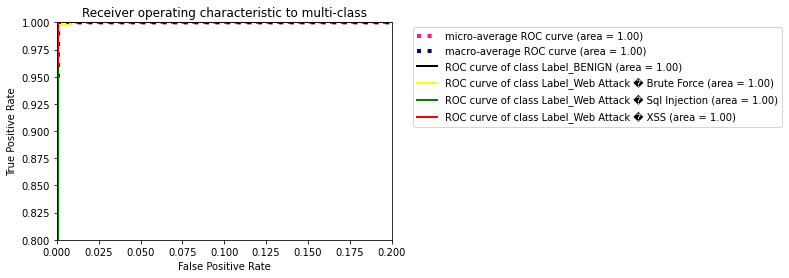

In [32]:
target_class=[]
target_class=['Label_BENIGN', 'Label_Web Attack � Brute Force',
       'Label_Web Attack � Sql Injection', 'Label_Web Attack � XSS']

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

pred1 = model.predict(x_test_2)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_2.ravel(), pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['black', 'yellow', 'green','red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#zoom in the plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['black', 'yellow', 'green','red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()